# Information Processing

In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

## Section 1 - Spikes and Rates

### Data retrieval

We consider a subset of data from a study of [Steinmetz et al. (2019)](https://www.nature.com/articles/s41586-019-1787-x). In this study, Neuropixels probes were implanted in the brains of mice. Electrical potentials were measured by hundreds of electrodes along the length of each probe. Each electrode’s measurements captured local variations in the electric field due to nearby spiking neurons. A spike sorting algorithm was used to infer spike times and cluster spikes according to common origin: a single cluster of sorted spikes is causally attributed to a single neuron.

In the experiment, mice earned water rewards by turning a wheel to indicate which of two visual gratings had higher contrast, or by not turning if no stimulus was presented
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_4/static/task_steinmetz.png" width="350"/>
</div>

We first load the data by executing the cell below. (This can take some time)

In [2]:
# https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files

# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

### First look at the data

The dataset is rather rich (you can have a look here: [dataset information](https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files)) we will only look a spike trains from this dataset. 

The data is arranged in a list, with every item in the list being a single session (one animal at a particular day).
The data in these entries is then stored in dictionaries. 
You can create a dictionary in python with the command: 

```python
example_dict = dict(
    key_1 = 'hello',
    another_key = [1,2,3],
)

example_dict = {
    'key_1' : 'hello',
    'another_key' : [1,2,3],
}
```

You can then access the dictionary with 

```python
print (example_dict['key_1'])
```


We are now interested in they key ['spks']. 
This gives us a numpy array of binned spike trains. the bin-size is 10 ms. The array has three dimensions: 

(neurons, trials, time_bins)

This means for example we can get the 15th neurons response of the first trial with:

```python
alldat[1]['spks'][9,0,:]
```
the colon (:) means we want to take every element along that dimension



array shape (1070, 251, 250)
example of how the binned single trial looks like, 
       each 1 represents a spike for that particular neuron: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0]


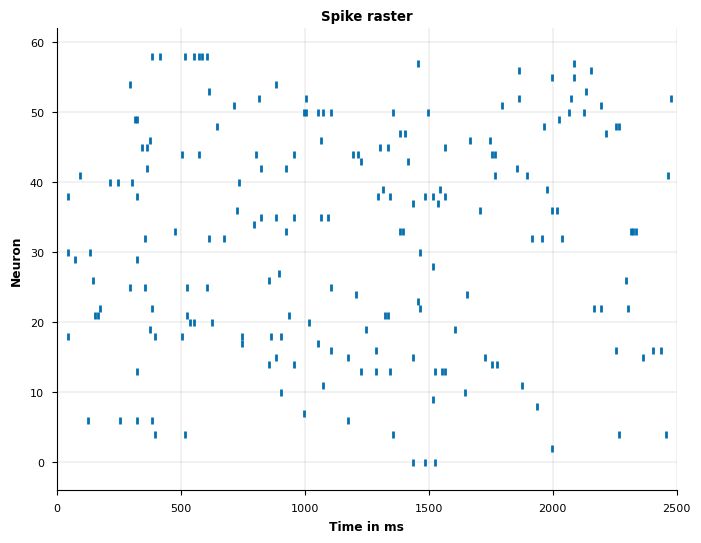

In [12]:
dat = alldat[1]
# neurons, trials, time_bins
print ('array shape', dat['spks'].shape)

single_trial = dat['spks'][0,0,:]

print ('''example of how the binned single trial looks like, 
       each 1 represents a spike for that particular neuron: \n''', single_trial)

def transform_to_event_input(binned_spikes):
    bin_size = 10
    bin_offset = 5
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times

    
    
fig, ax = plt.subplots()

for ii in range(0,60):
    _, spike_times = transform_to_event_input(dat['spks'][14,ii,:])
    ax.eventplot(spike_times, lineoffsets=ii)

ax.set(
    title = 'Spike raster',
    xlim = (0,2500),
    xlabel = 'Time in ms',
    ylabel = 'Neuron'
);

### Translate the spike trains into firing rates

We can now smooth each spike train, by applying a filter to that spike train. Execute the two cells below, so you can try out what it looks like.  

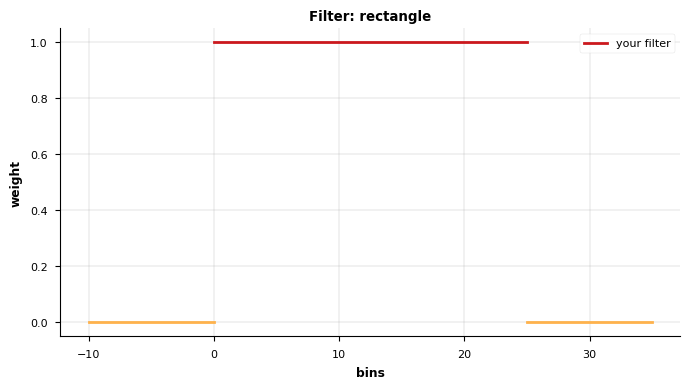

In [21]:
def get_filter_array(
        filter_shape = 'rectangle', 
        plot_filter_shape = False,
        return_filter_names = False,):
    ''' this function returns the filter array of a given shape (filter_shape) that needs to be a string'''
    
    ''' 
        when adding a new filter, be sure to update the list "all_filter_names" and add a new 
        if condition with the new filter name.
    '''
    
    
    all_filter_names = ['rectangle']
    if return_filter_names:
        # we implement this to make the interactive select option easiert to maintain
        return all_filter_names
    
    filter_array = np.array([])
    
    if filter_shape == 'rectangle':
        filter_array = np.ones(25)
        
        
    if filter_array.size == 0:
        print ('ERRRO: The name you provided for "filter_shape" does not match any of your if conditions')
        raise ValueError
        
        
        
    if plot_filter_shape:
        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(np.linspace(-10,0,10),np.zeros(10), c='#feb24c')
        ax.plot(np.linspace(0,len(filter_array),len(filter_array)),filter_array, c='#cb181d', label='your filter')
        ax.plot(np.linspace(len(filter_array),len(filter_array)+10,10),np.zeros(10), c='#feb24c')
        ax.set(
            title = f'Filter: {filter_shape}',
            xlabel = 'bins',
            ylabel = 'weight')
        ax.legend()
    return filter_array

_ = get_filter_array(filter_shape = 'rectangle', 
                 plot_filter_shape = True)

In [6]:

def visualize_filtering(pos, filter_shape = 'rectangle', trial_number = 0):
    
    filter_array = get_filter_array(filter_shape = filter_shape)
            
            
        
        
    single_trial = dat['spks'][0,trial_number,:]
    
    
    shift_ = 80
    shifted_trial = np.hstack([np.zeros(shift_),single_trial, np.zeros(shift_)])
    
    bin_times, spike_times = transform_to_event_input(single_trial)
            
    
    fig,axes = plt.subplots(2)
    axes[0].eventplot(spike_times, label = 'spikes')
    axes[0].set(
    xlim = (0,2500),
    ylim = (-0.1,2.8))

    filter_backbone = np.zeros_like(shifted_trial)
    new_bin_times = np.hstack([np.zeros(shift_)*float('nan'),bin_times,np.zeros(shift_)*float('nan')])
    
    shifted_pos = pos + shift_
    filter_backbone[shifted_pos -len(filter_array)//2:shifted_pos +len(filter_array)//2+1] = filter_array
    axes[0].plot(new_bin_times, filter_backbone, color='#feb24c', label='filter')
    axes[0].plot([new_bin_times[shifted_pos],new_bin_times[shifted_pos]],[0,0.2],color='#de2d26', label='time point')
    axes[0].plot([new_bin_times[shift_+2],new_bin_times[shift_+27]],[0.2,0.2],color='k')
    axes[0].annotate('250 ms', xy=([new_bin_times[shift_+2], 0.25]),  xycoords='data',
            xytext=([new_bin_times[shift_+5], 0.25]), textcoords='data')
    
    axes[0].axis('off')
    axes[0].legend()
    
    filtered_signal = np.zeros_like(shifted_trial)
    for ii in range(shift_,shifted_pos):
        filtered = 100*len(filter_array) * np.mean(shifted_trial[ii-len(filter_array)//2:ii+len(filter_array)//2+1] * filter_array/np.sum(filter_array))
        filtered_signal[ii] = filtered

    
    axes[1].plot(new_bin_times, filtered_signal, label= 'rate')
    axes[1].legend()
    axes[1].set(
        xlim=(0,2500),
        xlabel = 'Time in ms',
        ylabel = 'Firing rate in Hz',
    )


widgets.interactive(visualize_filtering, 
                    pos = (0,250,1), 
                    filter_shape = get_filter_array(return_filter_names = True),
                   trial_number = (0,100,1))

interactive(children=(IntSlider(value=125, description='pos', max=250), Dropdown(description='filter_shape', o…

### Task 1

Above you see how a filter of a rectangle translates the spike train into a filtered, smooth version. You can come up with your own filters. 
Think of other filters that might lead to useful insights. 

you can implement the filters by changing the function two blocks above
'get_filter_array'

to define a filter you need to come up with the name for the filter.

1) add this name to the list 'all_filter_names'

2) add an if condition below the if condition that is already there and make the condition to match your new name
```python
if filter_shape == 'your new name':
        # do something
        
```

3) now in this condition, you need to define what your filter looks like. You need to create a numpy array that is not longer than 160 elements.


#### some examples to get started
```python
np.ones(10) 
```
an array of length and all entries have the value 1. 

you can be very specific in your creation. For example
```python
filter_array = np.array([1,4,2,7,8,19,20])
```
creates an array of the list that is inside

or you can use mathematical functions of numpy. For example:
```python
filter_array = np.sin(np.linspace(0,10,10))
```
uses the mathematical function sinus on x values that range from 0 to 10 in 10 steps

#### You can always check how your new filter looks by calling:
```python
_ = get_filter_array(filter_shape = 'your new name', 
                 plot_filter_shape = True)
```

Once you are happy with your filter, you can run the block above again, to use your filter on the spike train.

What do you think is a useful filter?
Does the whole process makes sense? What did you create?

### [Solution 1](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/e93ef538094966b69fb04ff6c8c80217.txt)




#  Calculating the PSTH (Peri-stimulus histogram)


### Task 2

Now you can investigate the trial averaged response of a single neuron. 

In [7]:
def multiple_trials(neuron_id = 70, filter_shape = 'large rectangle'):

    fig, (ax_0, ax_1, ax_2) = plt.subplots(3,1, sharex = True, gridspec_kw={'height_ratios': [3, 1,1]})
    n_trials = 100
    all_trials = np.zeros_like(dat['spks'][neuron_id,0,:])
    for trial_number in range(0,n_trials):
        single_trial = dat['spks'][neuron_id,trial_number,:]
        _, spike_times = transform_to_event_input(single_trial)
        ax_0.eventplot(spike_times, lineoffsets=trial_number)
        all_trials += single_trial
        
    ax_0.axvline(x = 500, c ='#99000d', linewidth = 1 , linestyle = '--', label='stimulus onset')

    ax_0.set(
        xlim = (0,2500),
        ylabel = 'Trial Number',
    )
    ax_0.legend()
    
    X = np.linspace(0,2490,250)
    ax_1.bar(X,all_trials, width=10)
    ax_1.set(
        ylabel = 'PSTH',
    )
    
    filter_array = get_filter_array(filter_shape = filter_shape)
    
    shift_ = 80
    shifted_array = np.hstack([np.zeros(shift_),all_trials, np.zeros(shift_)])
    
    filtered_array = np.zeros_like(shifted_array)
    for ii in range(shift_,250+shift_):
        filtered = len(filter_array) * np.mean(shifted_array[ii-len(filter_array)//2:ii+len(filter_array)//2+1] * filter_array/np.sum(filter_array))
        filtered_array[ii] = filtered
    
    
    ax_2.plot(X,filtered_array[shift_:-shift_])
    ax_2.set(
        xlabel = 'Time in ms',
        ylabel = 'Smooth PSTH',
        
    )

    
    
widgets.interactive(multiple_trials, 
                    neuron_id = (0,100,1),
                   filter_shape = get_filter_array(return_filter_names = True))

interactive(children=(IntSlider(value=70, description='neuron_id'), Dropdown(description='filter_shape', optio…

## [A more detailed lecture on spikes to rates](https://www.youtube.com/watch?v=Ef7_qnLOh70)

## [Philosophy of the Spike: Rate-Based vs. Spike-Based Theories of the Brain](https://www.frontiersin.org/articles/10.3389/fnsys.2015.00151/full)

---
# Section 2: Optimization and Information

(This is in part taken from the [neuromatch academy](https://compneuro.neuromatch.io/tutorials/W1D1_ModelTypes/student/W1D1_Tutorial3.html) , an amazing resource for neuroscience content)

Neurons can only fire so often in a fixed period of time, as the act of emitting a spike consumes energy that is depleted and must eventually be replenished. To communicate effectively for downstream computation, the neuron would need to make good use of its limited spiking capability. This becomes an optimization problem: 

What is the optimal way for a neuron to fire in order to maximize its ability to communicate information?

In order to explore this question, we first need to have a quantifiable measure for information. Shannon introduced the concept of entropy to do just that, and defined it as

\begin{equation}
H_b(X) = -\sum_{x\in X} p(x) \log_b p(x)
\end{equation}

where $H$ is entropy measured in units of base $b$ and $p(x)$ is the probability of observing the event $x$ from the set of all possible events in $X$. See the Bonus Section 1 for a more detailed look at how this equation was derived.

The most common base of measuring entropy is $b=2$, so we often talk about *bits* of information, though other bases are used as well (e.g. when $b=e$ we call the units *nats*).

First, let's explore how entropy changes between some simple discrete probability distributions. In the rest of this exercise we will refer to these as probability mass functions (PMF), where $p(x_i)$ equals the $i^{th}$ value in an array, and mass refers to how much of the distribution is contained at that value.

### Now we look at a very simple PMF


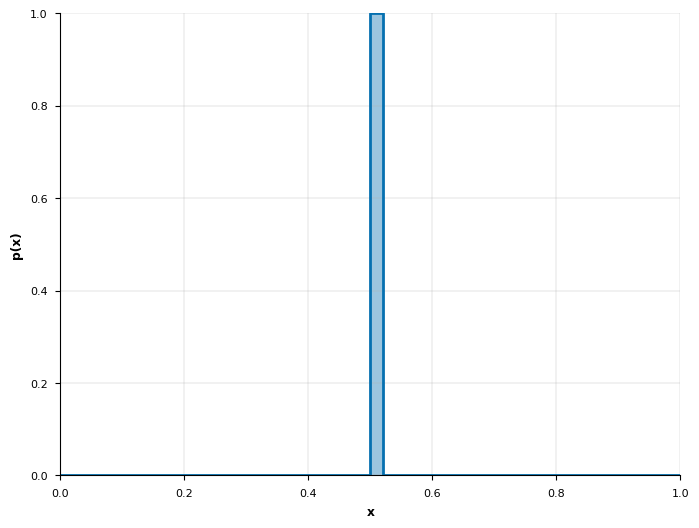

In [8]:
n_bins = 50  # number of points supporting the distribution
x_range = [0,1]
bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass


pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
fig, ax = plt.subplots()
ax.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
ax.fill_between(bins, pmf_, step="pre", alpha=0.4)

ax.set(
    xlabel = "x",
    ylabel = "p(x)",
    xlim = x_range,
    ylim = (0, 1));

If we were to draw a sample from this distribution, we know exactly what we would get every time. Distributions where all the mass is concentrated on a single event are known as *deterministic*.

### Task 3 - How much entropy is contained in a deterministic distribution? 

implement the entropy function (see equation above) to calculate the entropy of PMFs in bits.

In [25]:
def entropy(pmf):
  '''
  Given a discrete distribution, return the Shannon entropy in bits.
  This is a measure of information in the distribution.
  '''

  return 0 ## you need to remove this line
  
  # reduce to non-zero entries to avoid an error from log2(0)
  pmf = ...

  # implement the equation for Shannon entropy (in bits)
  h = ...

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)


# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


### [Solution Taks 3](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/55fb97641ef3f37a13eed8e5a19f663a.txt)





### What is the entropy of?

A mass split equally between two points?

0.00 bits


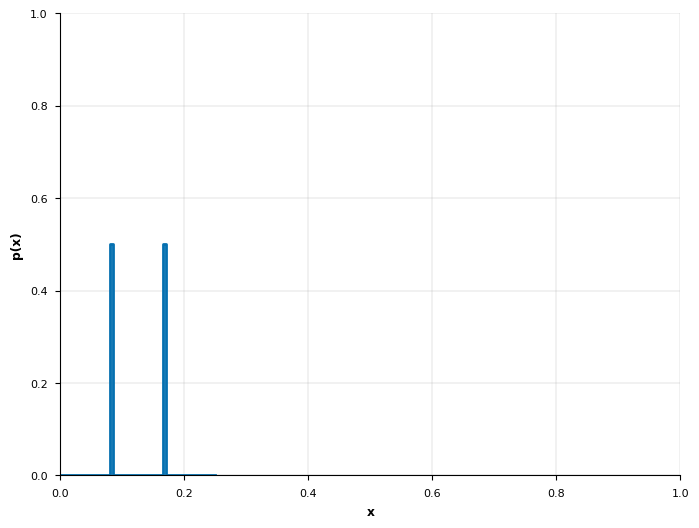

In [26]:
pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
fig, ax = plt.subplots()
ax.plot(bins, pmf_, drawstyle="steps")
ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
ax.set(
    xlabel = "x",
    ylabel = "p(x)",
    xlim = x_range,
    ylim = (0, 1));

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

Here, the entropy calculation is: $-(0.5 \log_2 0.5 + 0.5\log_2 0.5)=1$

There is 1 bit of entropy. This means that before we take a random sample, there is 1 bit of uncertainty about which point in the distribution the sample will fall on: it will either be the first peak or the second one.

Likewise, if we make one of the peaks taller (i.e. its point holds more of the probability mass) and the other one shorter, the entropy will decrease because of the increased certainty that the sample will fall on one point and not the other: :  −(0.2log20.2+0.8log20.8)≈0.72

### Task 4

Try changing the definition of the number and weighting of peaks, and see how the entropy varies.

What is the maximum entropy you can achieve?

0.00 bits


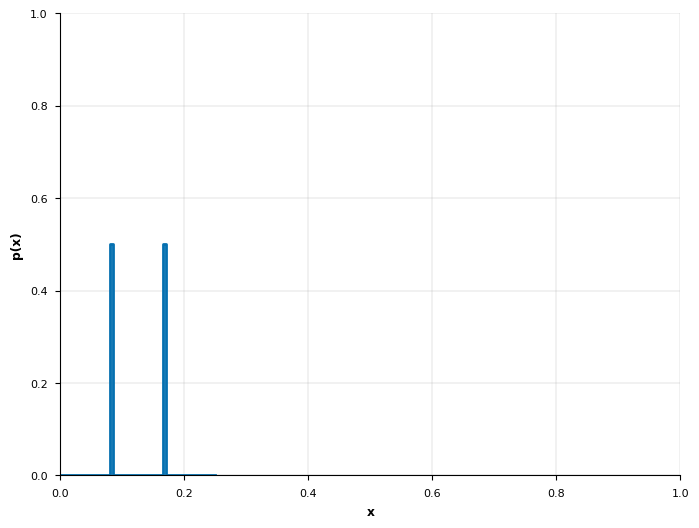

In [27]:
n_bins = 50
pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
fig, ax = plt.subplots()
ax.plot(bins, pmf_, drawstyle="steps")
ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
ax.set(
    xlabel = "x",
    ylabel = "p(x)",
    xlim = x_range,
    ylim = (0, 1));

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

### [Solution 4](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/52e697641ef3f37a5faed8e5a19f663a.txt)



### Task 5

Now let's think about spike coding in neurons. Assuming that the information is encoded in the interspike-intervals, we can now ask how much information different types of neurons contain. 

Let's assume three different neurons that have the following ISI distributions:

1) Deterministic
2) Uniform
3) Exponential

In addition, we now add a constraint. In order to fire, neurons consume energy, therefore we constraint the number of spikes a neuron can emmit. This means we constrain the firing rate. The firing rate is the inverse of the mean of the Inter-Spike-Interval (ISI) distribution (this will be discussed in the next lecture in more detail) 

Now we can ask the question: 
If the neuron has a fixed bugdet of spikes, what is the ISI distribution it should express in order to transmit the most information?

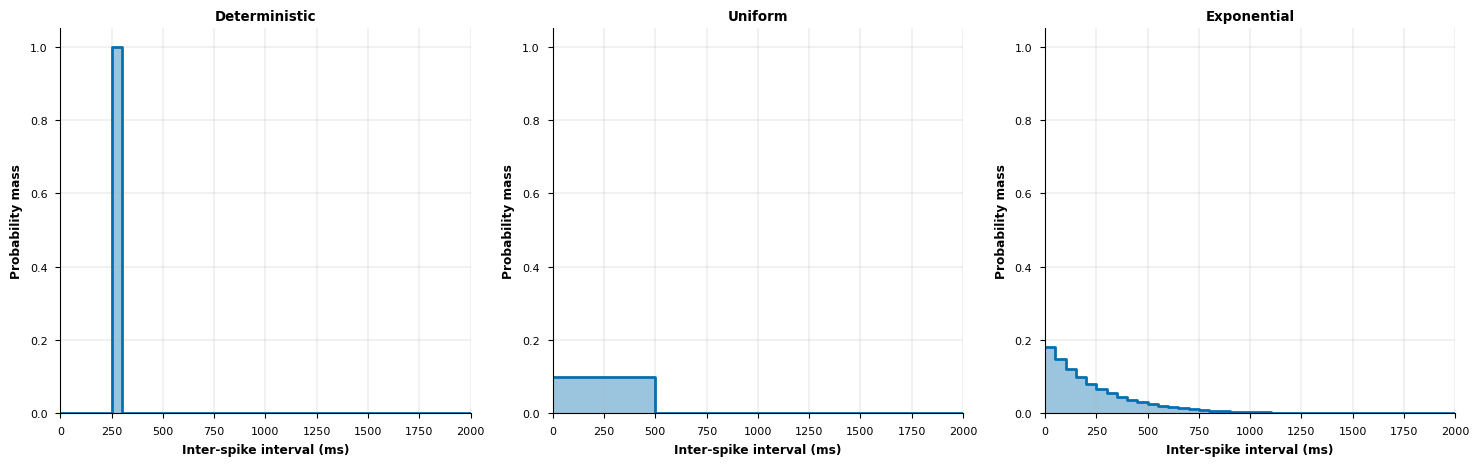

In [33]:
n_bins = 50
mean_isi = 250
isi_range = (0, 2500)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = scipy.stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

fig, axes = plt.subplots(1,3, figsize=(18, 5))

dists =  [# (subplot title, pmf, ylim)
          ("Deterministic", pmf_single, (0, 1.05)),
          ("Uniform", pmf_uniform, (0, 1.05)),
          ("Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (ms)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim((0,2000));
  ax.set_ylim(ylim);

In [29]:
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

Deterministic: 0.00 bits
Uniform: 0.00 bits
Exponential: 0.00 bits


Under the constraint of a fixed number of spikes, the exponential distribution is actually the better choice then the uniform distribution, since it contains highly surprising elements (few very long ISIs) 

But how does this work in combination with the statement we had above about the uniform distribution having the highest entropy?

We can now look at real neurons from the exampe in the beginning again. Therefore we need to create a histogram of the ISIs of these neurons. We can do this either in the passive condition (no stimulus shown - 'spks_passive') or in the active condition 'spks'. (you can change it in the code below)

We can gather all ISIs across the different trials. Then, we need to normalize the histogram in order to get a PMF.
This we can then use again to calculate the Information that the spikes contain.

In [30]:
def entropy_of_real_neruons(neuron_idx = 14):
    all_isi = np.array([])
    for ii in range(150):
        _, spike_times = transform_to_event_input(dat['spks_passive'][neuron_idx,ii,:])
        if len(spike_times) > 1: # we this to avoid artefacts
            isi = np.diff(np.sort(spike_times))
            all_isi = np.hstack([all_isi,isi])
    #         ax.eventplot(spike_times, lineoffsets=ii)

    bins = np.linspace(0,2100, 50 + 1)
    counts, _ = np.histogram(all_isi, bins)

    pmf = counts / np.sum(counts) # we create a pmf as above by normalizing

    ymax = max(0.2, 1.05 * np.max(pmf))
    pmf_ = np.insert(pmf, 0, pmf[0])

    fig, ax = plt.subplots()
    ax.plot(bins, pmf_, drawstyle="steps")
    ax.fill_between(bins, pmf_, step="pre", alpha=0.4)

    ax.set(title = f"Neuron {neuron_idx} with {entropy(pmf):.2f} bits",
           xlabel = "Inter-spike interval (ms)",
           ylabel = "Probability mass",
           xlim  = [0, 2100],
           ylim  = [0, ymax])

widgets.interactive(entropy_of_real_neruons, neuron_idx = (0,100,1))

interactive(children=(IntSlider(value=14, description='neuron_idx'), Output()), _dom_classes=('widget-interact…